## **8. Regression**

### **8-1. 선형회귀**

#### 8-1-1. 단순선형회귀
- 가정: **잔차의 정규성/등분산성/독립성** (독립변수는 서로 선형적으로 독립) + 선형성
- 전처리
  1) 이상치, 결측치 처리
  2) 범주형 변수: n-1개 더미코딩 (원핫인코딩은 다중공선성 문제로 사용 X)
  3) 영향치: Leverage H, Cook's distance 등으로 레버리지 측정
  4) 다중공선성: 지식/직관을 이용한 일부 제거, 변수 선택법, VIF 계산 등
  5) 종속변수 스케일링: 등분산성 or 정규성 위반 시 Box-cox, 로그 변환 등 시도
- 잔차 분석: 모델 적합 후 잔차 가정 위반시 전처리 재실시 or 데이털 리샘플링

In [16]:
from sklearn.datasets import load_diabetes
from pandas import DataFrame
import numpy as np
data = load_diabetes() # 데이터 불러오기
Xa = data['data']
ya = data['target']
diabetes = DataFrame(np.c_[Xa, ya], columns = data['feature_names']+['target'])

# 단순 선형 회귀 적합을 위해 전체 데이터에서 1개의 설명변수와 1개의 종속변수를 추출
X = np.array(diabetes.filter(['bmi'])).ravel() #numpy로 계산하기 위해 데이터 형태 변환
Y = np.array(diabetes.filter(['target'])).ravel()
print("데이터 확인: ", X[:3], Y[:3])

데이터 확인:  [ 0.06169621 -0.05147406  0.04445121] [151.  75. 141.]


In [17]:
print("[수기 적합]")
Xm = np.mean(X)
Ym = np.mean(Y)
w = sum((X-Xm)*(Y-Ym)) / sum((X-Xm)**2) #기울기
b = Ym - w*Xm #절편
print(" 기울기 점추정량: {:.3f}".format(w))
print(" 절편 점추정량: {:.3f}".format(b))
print(" 표본회귀식: Y = {:.3f} + {:.3f}*X".format(b, w))

[수기 적합]
 기울기 점추정량: 949.435
 절편 점추정량: 152.133
 표본회귀식: Y = 152.133 + 949.435*X


In [18]:
Ypred = b + X*w #기울기, 절편 추정량으로 구한 예측값
SSR = sum((Ym-Ypred)**2)
SSE = sum((Y-Ypred)**2)
SST = sum((Y-Ym)**2)
R2 = SSR / SST
R = np.corrcoef(X,Y)[0][1] #X, Y의 상관계수
print(" 결정계수(= R2): {:.3f}(= {:.3f})".format(R2, R**2))
print(" 상관계수(= R): {:.3f}(= {:.3f})".format(R, np.sqrt(R2)))
## X, Y의 상관계수의 제곱은 X, Y로 적합한 단순 선형회귀 모델의 결정계수와 같다.

 결정계수(= R2): 0.344(= 0.344)
 상관계수(= R): 0.586(= 0.586)


In [19]:
# 회귀계수의 가설검정 (F검정, 유의수준 5%)
# H0: 모든 회귀계수는 0이다. H1: 적어도 하나의 회귀계수는 0이 아니다.
from scipy.stats import f, t
treat_df = 1 #처리의 자유도 (설명변수의 개수)
resid_df = len(X)-treat_df-1 #잔차의 자유도 (전체 데이터의 개수 - 설명변수의 개수 -1)
MSR = SSR / treat_df
MSE = SSE / resid_df
fstat = MSR / MSE
print(" MSE: {:.3f}, MSR: {:.3f}, F통계량 {:.3f}".format(MSE, MSR, fstat))
print(" 가설검정: F({}, {}) p-value {:.3f}".format(treat_df, resid_df, 1-f.cdf(fstat, treat_df, resid_df)))

 MSE: 3908.140, MSR: 901427.314, F통계량 230.654
 가설검정: F(1, 440) p-value 0.000


In [20]:
print("[라이브러리 적합]")
# statsmodel 방법
import statsmodels.api as sm
X = diabetes.filter(['bmi'])
Y = diabetes.filter(['target'])

Xc = sm.add_constant(X) #절편 추가
model = sm.OLS(Y, Xc) # 잔차제곱합을 최소화 하는 ordinary least squares
fitted = model.fit()
resid = fitted.resid #모델의 잔차 추출
print(fitted.summary()) #모델 결과 요약

[라이브러리 적합]
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     230.7
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           3.47e-42
Time:                        15:15:53   Log-Likelihood:                -2454.0
No. Observations:                 442   AIC:                             4912.
Df Residuals:                     440   BIC:                             4920.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.974     51.1

In [21]:
# sklearn 방법
from sklearn.linear_model import LinearRegression
X = diabetes.filter(['bmi'])
Y = diabetes.filter(['target'])

LR = LinearRegression()
LR.fit(X, Y)
pred = LR.predict(X) # 회귀모델로 X값에 대한 예측값 생성

print("회귀계수: ", LR.coef_) 
print("절편: ", LR.intercept_)
print("결정계수: {:.3f}".format(LR.score(X, Y)))

회귀계수:  [[949.43526038]]
절편:  [152.13348416]
결정계수: 0.344


In [22]:
## 기울기, 절편, Y의 평균값에 대한 추정과 검정
print("[추정과 검정]")
X = np.array(diabetes.filter(['bmi'])).ravel() #numpy로 계산하기 위해 데이터 형태 변환
Y = np.array(diabetes.filter(['target'])).ravel()

## resid_std를 계산하여 세가지 추정과 검정에 사용
resid_std = np.sqrt(MSE)
resid_std2 = np.std(fitted.resid, ddof=2)
print("잔차 표준오차: {:.3f}(= {:.3f})".format(resid_std, resid_std2))

[추정과 검정]
잔차 표준오차: 62.515(= 62.515)


In [23]:
print(" 1. 기울기: ")
# 기울기의 추정
print("  점추정량: {:.3f}".format(w))
SE = resid_std / np.sqrt(sum((X-Xm)**2)) # 잔차표준편차 / X편차의 제곱합
print("  점추정량의 표준오차: {:.3f}".format(SE))
conf_a = 0.05
start = w + t.ppf(conf_a/2, resid_df)*SE 
end = w + t.ppf(1-conf_a/2, resid_df)*SE
print("  신뢰구간: {:.3f}~{:.3f}".format(start, end))

# 기울기의 가설검정 (t검정, 유의수준 5%)
# H0: 기울기 w0는 0이다, H1: 기울기 w0는 0이 아니다.
test_a = 0.05
w0 = 0
tstat = (w - w0) / SE
print("  검정통계량 {:.3f}, p-value {:.3f}".format(tstat, (1-t.cdf(tstat, resid_df))*2))

 1. 기울기: 
  점추정량: 949.435
  점추정량의 표준오차: 62.515
  신뢰구간: 826.570~1072.301
  검정통계량 15.187, p-value 0.000


In [24]:
print(" 2. 절편: ")
# 절편의 추정 
Xi = 0
Y1 = b + w*Xi
print("  점추정량: {:.3f}".format(Y1)) #절편의 기댓값
SE2 = resid_std * np.sqrt(1/len(X) + (Xi-Xm)**2/sum((X-Xm)**2))
print("  점추정량의 표준오차: {:.3f}".format(SE2))
start2 = Y1 + t.ppf(conf_a/2, resid_df)*SE2 
end2 = Y1 + t.ppf(1-conf_a/2, resid_df)*SE2
print("  신뢰구간: {:.3f}~{:.3f}".format(start2, end2))

# 절편의 가설검정 (t검정, 유의수준 5%)
# H0: 절편 b0는 0이다, H1: 절편 b0는 0이 아니다.
test_a = 0.05
b0 = 0
tstat2 = (b-b0) / SE2
print("  검정통계량 {:.3f}, p-value {:.3f}".format(tstat2, (1-t.cdf(np.abs(tstat2), resid_df))*2))

 2. 절편: 
  점추정량: 152.133
  점추정량의 표준오차: 2.974
  신뢰구간: 146.289~157.978
  검정통계량 51.162, p-value 0.000


In [27]:
Xi = 0.15 ### X값 입력
print(f" 3. 특정한 X값 {Xi:.2f}일 때 Y의 평균값: ")
# Y의 평균값의 추정
Y2 = b + w*Xi
print("  점추정량: {:.3f}".format(Y2))
SE3 = resid_std * np.sqrt(1/len(X) + (Xi-Xm)**2/sum((X-Xm)**2))
print("  점추정량의 표준오차: {:.3f}".format(SE3))

start3 = Y2 + t.ppf(conf_a/2, resid_df)*SE3 
end3 = Y2 + t.ppf(1-conf_a/2, resid_df)*SE3
print("  신뢰구간: {:.3f}~{:.3f}".format(start3, end3))

# Y 평균값의 가설검정 (t검정, 유의수준 5%)
# H0: Y2_0는 0이다, H1: Y2_0는 0이 아니다.
test_a = 0.05
Y2_0 = 0
tstat3 = (Y2-Y2_0) / SE3
print("  검정통계량 {:.3f}, p-value {:.3f}".format(tstat3, (1-t.cdf(np.abs(tstat3), resid_df))*2))

 3. 특정한 X값 0.15일 때 Y의 평균값: 
  점추정량: 294.549
  점추정량의 표준오차: 9.837
  신뢰구간: 275.215~313.883
  검정통계량 29.942, p-value 0.000


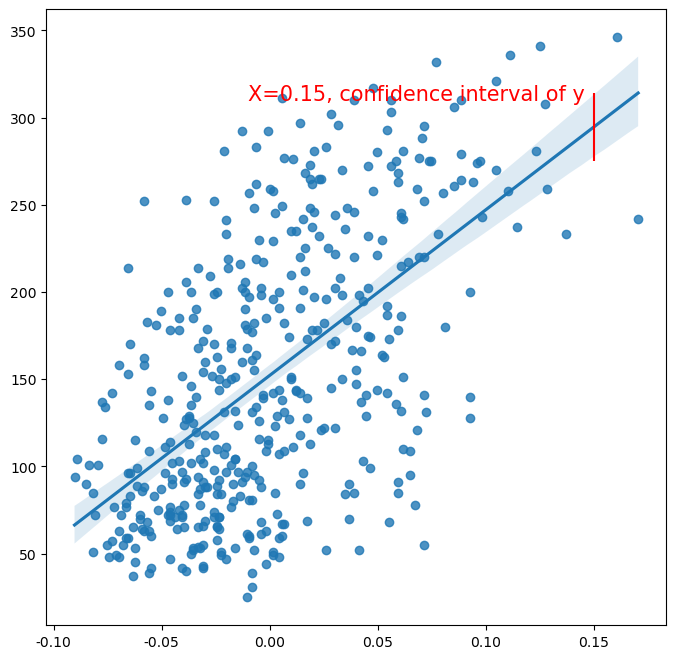

In [26]:
# 회귀직선의 신뢰대(각 X값에 대한 Y 평균값들의 신뢰구간) 시각화
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams['font.family'] = 'D2Coding'

fig, ax = plt.subplots(1,1)
sns.regplot(x=X, y=Y, ax=ax)
ax.vlines(x=0.15, ymin=start3, ymax=end3, color='red')
ax.text(-0.01, 310, f"X={Xi}, confidence interval of y", color='red', size=15)
plt.show()

#### 8-1-2. 다중선형회귀

In [41]:
from sklearn.datasets import load_diabetes
import statsmodels.api as sm
import numpy as np
from pandas import DataFrame
data = load_diabetes() # 데이터 불러오기
Xa = data['data']
ya = data['target']
diabetes = DataFrame(np.c_[Xa, ya], columns = data['feature_names']+['target'])

# 다중 선형 회귀 적합을 위해 전체 데이터에서 4개의 설명변수와 1개의 종속변수를 추출
X = diabetes.filter(['bmi', 'age', 'sex', 'bp'])
y = diabetes.filter(['target'])

# 회귀 분석 fitted객체, 요약결과 반환하는 함수 정의
def multiR_fitted(X, y): #return fitted, summary
    X_ = sm.add_constant(X)
    model = sm.OLS(y, X_)
    fitted = model.fit()
    return fitted, fitted.summary()

fitted, summary = multiR_fitted(X, y)
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     72.91
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           2.70e-47
Time:                        15:41:33   Log-Likelihood:                -2434.2
No. Observations:                 442   AIC:                             4878.
Df Residuals:                     437   BIC:                             4899.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.853     53.329      0.0

#### 영향치 판단
- 총 4가지 방법: Cook's distance, DFBETAS, DFFITS, Leverage H

In [42]:
# 각 데이터의 영향치 판단값 계산
def get_influence(fitted):
    cook = fitted.get_influence().cooks_distance[0]
    dfb = fitted.get_influence().dfbetas[:,0]
    dff = fitted.get_influence().dffits_internal[0]
    lev = fitted.get_influence().hat_matrix_diag
    df = DataFrame({"cooks_distance":cook, 
                       'dfbetas':dfb, 'dffits':dff,
                      'leverageH':lev})
    return df

influ_df = get_influence(fitted)  
print(influ_df)

     cooks_distance   dfbetas    dffits  leverageH
0          0.001516 -0.043867 -0.087062   0.008908
1          0.000350 -0.024198 -0.041811   0.006743
2          0.001478 -0.033422 -0.085965   0.014950
3          0.003736  0.061662  0.136681   0.011133
4          0.000003 -0.002047 -0.003822   0.007869
..              ...       ...       ...        ...
437        0.000049 -0.008507 -0.015638   0.007629
438        0.000002 -0.001460 -0.003347   0.011865
439        0.000045 -0.008749 -0.015046   0.006677
440        0.000531  0.026808  0.051509   0.008339
441        0.000031 -0.005440 -0.012411   0.011747

[442 rows x 4 columns]


In [43]:
# 다른 라이브러리도 존재
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(fitted)
cook_d = influence.cooks_distance[0]
print(cook_d)

0      0.001516
1      0.000350
2      0.001478
3      0.003736
4      0.000003
         ...   
437    0.000049
438    0.000002
439    0.000045
440    0.000531
441    0.000031
Length: 442, dtype: float64


In [44]:
# 영향치로 판단되는 데이터 추출하기
def find_idx_cooks(fitted):
    cook = fitted.get_influence().cooks_distance[0]
    P = fitted.get_influence().k_vars #변수의 개수
    score = 4 / (len(y) - P - 1)
    if score <= 1:
        idx = np.where(cook > score)[0]
    else:
        idx = np.where(cook > 1)[0]
    return idx

idx = find_idx_cooks(fitted) #영향치의 인덱스
print("Cook's distance 기준 영향치: ", idx)

Cook's distance 기준 영향치:  [  9  78  92 102 117 141 147 152 204 211 256 289 328 336 343 380 417]


In [45]:
### Cook's distance - AI 검증 코드 ###

def find_idx_cooks(fitted):
    cook = fitted.get_influence().cooks_distance[0]  # Cook's distance 추출
    n = len(fitted.model.endog)  # 종속변수 관측치 수 (y의 길이)
    P = fitted.get_influence().k_vars # 변수의 개수 (상수항 포함) 
    score = 4 / (n-P-1)  # 보수적으로 1 적용 가능 (강한 영향력만 식별)
    idx = np.where(cook > score)[0]
    return idx

# 실행 예시
idx = find_idx_cooks(fitted)
print("Cook's distance 기준 영향치: ", idx)

Cook's distance 기준 영향치:  [  9  78  92 102 117 141 147 152 204 211 256 289 328 336 343 380 417]


In [46]:
def find_idx_dfbetas(fitted):
    dfb = fitted.get_influence().dfbetas[:,0]
    n = fitted.df_resid + fitted.df_model + 1
    score = 2/np.sqrt(n)
    if score <= 2:
        idx = np.where(dfb > score)[0]
    else:
        idx = np.where(dfb > 2)[0]
    return idx
idx2 = find_idx_dfbetas(fitted)
print("DFBETAS 기준 영향치: ", idx2)

DFBETAS 기준 영향치:  [  9  37  78 102 141 152 190 218 359 364]


In [47]:
### DFBETAS - AI 검증 코드 ###

def find_idx_dfbetas(fitted, coef_idx=1):  # coef_idx: 검증할 계수 인덱스 (기본값: 첫 번째 독립변수)
    dfb = fitted.get_influence().dfbetas[:, coef_idx]  # 특정 계수 선택
    n = fitted.nobs  # 단순하고 직관적인 n 계산
    score = 2 / np.sqrt(n)
    idx = np.where(np.abs(dfb) > score)[0]  # 절대값 적용
    return idx

# 사용 예시 (첫 번째 독립변수 계수 검증)
idx2 = find_idx_dfbetas(fitted, coef_idx=1)
print("DFBETAS 기준 영향치: ", idx2)

DFBETAS 기준 영향치:  [  8   9  27  32  56  78  97 102 104 117 135 138 141 147 172 218 252 256
 259 261 289 290 300 304 310 328 336 367 376 407 417]


In [48]:
def find_idx_dffits(fitted):
    dff = fitted.get_influence().dffits_internal[0]
    P = fitted.get_influence().k_vars
    n = fitted.df_resid + fitted.df_model + 1
    score = 2*np.sqrt((P+1)/n)
    idx = np.where(dff > score)[0]
    return idx
idx3 = find_idx_dffits(fitted)
print("DFFITS 기준 영향치: ", idx3)

DFFITS 기준 영향치:  [  9 102 117 141 256]


In [49]:
### DFFITS - AI 검증 코드 ###

def find_idx_dffits(fitted):
    dff = fitted.get_influence().dffits_internal[0]
    P = fitted.get_influence().k_vars  # 독립변수 수 (상수항 포함)
    n = fitted.nobs  # 표본 크기 직접 추출
    score = 2 * np.sqrt(P / n)  # 올바른 임계값 공식
    idx = np.where(np.abs(dff) > score)[0]  # 절대값 적용
    return idx

# 실행 예시
idx3 = find_idx_dffits(fitted)
print("DFFITS 기준 영향치: ", idx3)

DFFITS 기준 영향치:  [  9  78  92 102 117 141 147 152 204 211 256 289 328 336 343 380 417]


In [50]:
def find_idx_leverageH(fitted):
    lh = fitted.get_influence().hat_matrix_diag
    P = fitted.get_influence().k_vars
    n = fitted.df_resid + fitted.df_model + 1
    score = 2*(P+1)/n
    idx = np.where(lh > score)[0]
    return idx
idx4 = find_idx_leverageH(fitted)
print("Leverage H 기준 영향치: ", idx4)

Leverage H 기준 영향치:  [130 145 256 261 340 366 367 408]


In [51]:
### Leverage H - AI 검증 코드 ###

def find_idx_leverageH(fitted):
    lh = fitted.get_influence().hat_matrix_diag  # 레버리지 값 추출
    P = fitted.get_influence().k_vars  # 상수항 포함한 독립변수 수
    n = fitted.nobs  # 표본 크기 직접 추출
    score = 2 * P / n  # 올바른 임계값 공식
    idx = np.where(lh > score)[0]  # 인덱스 배열 추출
    return idx

# 실행 예시
idx4 = find_idx_leverageH(fitted)
print("Leverage H 기준 영향치: ", idx4)

Leverage H 기준 영향치:  [ 10  71 130 145 251 256 261 262 278 311 327 340 366 367 407 408 422]


#### VIF 계산
VIF 10 이상이면, 설명변수들이 높은 상관성을 가짐

In [55]:
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

def check_vif(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    model.fit()
    vif_df = DataFrame(columns=['feature', 'VIF'])
    for i in range(1, len(model.exog_names)):
        vif_df.loc[i, 'feature'] = model.exog_names[i]
        vif_df.loc[i, 'VIF'] = round(VIF(model.exog, i), 3)
    return vif_df.sort_values('VIF', ascending=False)

print(check_vif(X, y))

## 모든 feature들의 VIF가 10 미만이기 때문에 다중공선성이 없다고 볼 수 있다.

  feature    VIF
4      bp  1.343
1     bmi   1.19
2     age  1.143
3     sex  1.073


#### 변수 선택과 가능도
- 변수 선택 기준: AIC, BIC 최소 / 수정 결정계수 최대 / Mallow's CP 값이 작고, 변수 개수와 유사
- 변수 선택 방법: 단계적방법, 전진선택법, 후진제거법

In [11]:
# 모든 변수를 포함한 full model
print("full model = const, bp, bmi, age, sex")
fitted, summary = multiR_fitted(X, y)
R2 = fitted.rsquared
n = fitted.nobs #number of observations
p = fitted.df_model #설명변수의 개수
constant = 'const' in fitted.params.keys() #절편 유무
SSE = sum((fitted.resid)**2) #full model의 잔차제곱합
MSE_full = SSE / (n-p-1) # fitted.mse_resid (MSE)
adj_R2 = 1- (1-R2)*(n-1)/(n-p-1)
print(" 수정 결정계수: {:.3f}".format(adj_R2))

#수기계산 및 라이브러리 계산
llf = -n/2*np.log(2*np.pi) - n/2*np.log(SSE / n) - n/2 #로그 가능도 값 (=fitted.llf)
aic = -2*llf + 2*(p + constant) #fitted.aic와 동일
bic = -2*llf + np.log(n)*(p + constant) #fitted.bic와 동일
print(" AIC: {:.1f}(= {:.1f})".format(aic, fitted.aic))
print(" BIC: {:.1f}(= {:.1f})".format(bic, fitted.bic))

cp = SSE/MSE_full - n + 2*(p+1)
print(" Cp {:.1f} -> 변수+상수 개수의 합 {}".format(cp, p+constant))

full model = const, bp, bmi, age, sex
 수정 결정계수: 0.395
 AIC: 4878.4(= 4878.4)
 BIC: 4898.8(= 4898.8)
 Cp 5.0 -> 변수+상수 개수의 합 5.0


In [14]:
# 일부 변수만 포함한 후보 model
print("후보 model = const, bp, bmi")
fitted2, summary2 = multiR_fitted(X.filter(['bp', 'bmi']), y)
n = fitted2.nobs #number of observations
p = fitted2.df_model #설명변수의 개수
constant = 'const' in fitted2.params.keys() #절편 유무
SSE2 = sum((fitted2.resid)**2) #후보 model의 잔차제곱합
adj_R2 = 1- (1-R2)*(n-1)/(n-p-1)
print(" 수정 결정계수: {:.3f}".format(adj_R2))

#수기계산 및 라이브러리 계산
llf = -n/2*np.log(2*np.pi) - n/2*np.log(SSE2 / n) - n/2 #로그 가능도 값
aic = -2*llf + 2*(p + constant)
bic = -2*llf + np.log(n)*(p + constant)
print(" AIC: {:.1f}(= {:.1f})".format(aic, fitted2.aic))
print(" BIC: {:.1f}(= {:.1f})".format(bic, fitted2.bic))

cp = SSE2/MSE_full - n + 2*(p+1) # 비교모델의 MSE가 아닌 위에서 구한 full모델의 MSE
print(" Cp {:.1f} -> 변수+상수 개수의 합 {}".format(cp, p+constant))

후보 model = const, bp, bmi
 수정 결정계수: 0.398
 AIC: 4877.5(= 4877.5)
 BIC: 4889.8(= 4889.8)
 Cp 4.1 -> 변수+상수 개수의 합 3.0


In [57]:
## 단계적 선택법
from pandas import DataFrame
import statsmodels.api as sm
from itertools import combinations
import numpy as np
def stepwise_method(X, y, criterion='AIC'): #'BIC', 'CP', 'adj_R2'
    result = DataFrame()
    feature_combis = [] #변수 조합의 모든 경우의 수
    for i in range(1, len(X.columns)+1):
        feature_combis += list(combinations(X.columns, i))
    feature_combis.reverse() #p개수 내림차순
    
    for j, feature_combi in enumerate(feature_combis):
        X_ = X.filter(feature_combi)
        X_ = sm.add_constant(X_) #절편 추가
        model = sm.OLS(y, X_)
        fitted = model.fit() #모델 적합
        n = fitted.nobs #number of observations
        p = fitted.df_model #설명변수의 개수
        if j==0:
            MSE_full = fitted.mse_resid # full모델의 MSE
        
        #각 기준값 계산
        aic = fitted.aic
        bic = fitted.bic
        cp = sum((fitted.resid)**2)/MSE_full - (n-2*(p+1))
        adj_R2 = fitted.rsquared_adj
        
        #각 기준값 입력
        result.loc[j, 'feature_combi'] = ", ".join(list(fitted.params.keys()))
        result.loc[j, 'AIC'] = aic
        result.loc[j, 'BIC'] = bic
        result.loc[j, 'CP'] = cp
        result.loc[j, 'adj_R2'] = adj_R2
        
        if criterion in ['AIC', 'BIC']: #낮을수록 Best
            result = result.sort_values(by=criterion, ascending = True)
            best = result.iloc[0, 0]
        elif criterion in ['adj_R2']: #높을수록 Best
            result = result.sort_values(by=criterion, ascending = False)
            best = result.iloc[0, 0]
        elif criterion in ['CP']: #CP값이 작고, 변수의 개수와 유사할수록 Best
            best_idx = np.abs(result['CP']-result['feature_combi'].apply(lambda x: x.count(',')+1)).sort_values(ascending=True).index
            result = result.loc[best_idx, :]
            best = result.iloc[0, 0]
        else:
            print("criterion options only cover AIC, BIC, CP, adj_R2.")
    return best, result

In [58]:
# AIC 기준으로 단계적 선택법을 통한 최적의 변수 선택 결과는 다음과 같다.
best, result = stepwise_method(X, y, criterion='AIC')
print("최적의 변수 조합: ", best)
print(f"전체 결과값: \n{result}\n")

for c in ['AIC', 'BIC', 'CP', 'adj_R2']:
    best, result = stepwise_method(X, y, c)
    print(f"기준 {c}에 의한 최적의 변수 조합 {best}")

최적의 변수 조합:  const, bmi, sex, bp
전체 결과값: 
               feature_combi          AIC          BIC          CP    adj_R2
2        const, bmi, sex, bp  4876.695451  4893.060691    3.337350  0.395687
8             const, bmi, bp  4877.487843  4889.761772    4.109030  0.393242
0   const, bmi, age, sex, bp  4878.354373  4898.810922    5.000000  0.394771
3        const, bmi, age, bp  4879.321047  4895.686287    5.942980  0.392087
10           const, bmi, age  4909.624337  4921.898267   37.300027  0.347484
4       const, bmi, age, sex  4911.296550  4927.661789   38.949157  0.346479
14                const, bmi  4912.038221  4920.220840   40.050156  0.342433
9            const, bmi, sex  4913.987529  4926.261459   41.995333  0.341010
5             const, sex, bp  5002.163006  5014.436935  147.528327  0.195517
11                 const, bp  5002.507604  5010.690223  148.631889  0.193076
1        const, age, sex, bp  5002.828421  5019.193660  147.769066  0.196111
6             const, age, bp  5003.

#### 잔차 분석

In [69]:
from scipy.stats import zscore, probplot
import statsmodels.api as sm
X_ = sm.add_constant(X)
model = sm.OLS(y, X_)
fitted = model.fit()
resid = fitted.resid # 잔차
pred = fitted.fittedvalues #예측값
sresid = zscore(resid) #표준화 잔차

print("예측값: \n", pred[:5].values)
print("실제값: \n", y[:5].values.ravel())
print("잔차: \n", resid[:5].values)
print("표준화 잔차: \n", sresid[:5])

예측값: 
 [205.82990301 105.33173897 182.53724311 129.17349824 137.56394829]
실제값: 
 [151.  75. 141. 206. 135.]
잔차: 
 [-54.82990301 -30.33173897 -41.53724311  76.82650176  -2.56394829]
표준화 잔차: 
 0   -0.919418
1   -0.508620
2   -0.696520
3    1.288270
4   -0.042994
dtype: float64


1. 정규성 가정 확인: 
 Jarque-bera: stats 6.464, p-value 0.039
 왜도 0.146, 첨도 2.485


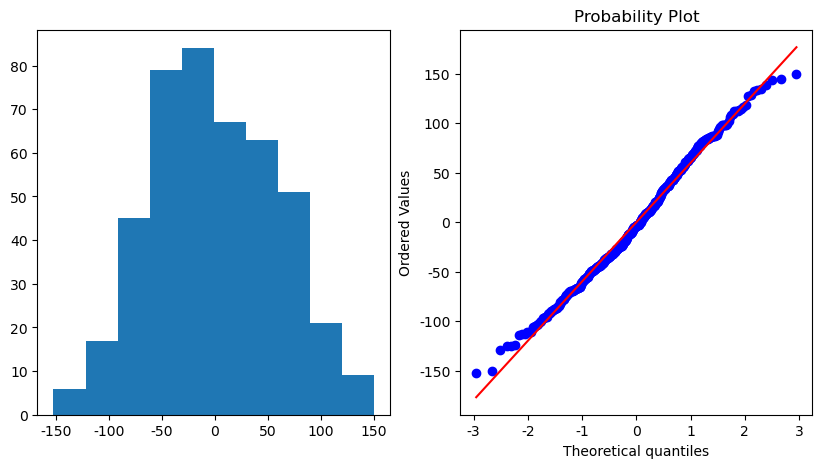

In [61]:
from matplotlib import pyplot as plt
from statsmodels.stats.stattools import jarque_bera
print("1. 정규성 가정 확인: ") #히스토그램, QQ plot, Jarque-Bera
stats, p, skew, kurt = jarque_bera(resid)
print(" Jarque-bera: stats {:.3f}, p-value {:.3f}".format(stats, p))
print(" 왜도 {:.3f}, 첨도 {:.3f}".format(skew, kurt))
## Jarque bera 검정 결과, 유의수준 0.05 기준으로 정규분포와 차이가 있다(H1).
## 정규분포는 왜도는 0, 첨도는 3을 따르는데 해당 기준으로는 다소 차이가 있다.

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(resid)
probplot(resid, plot=ax[1])
plt.show()
## 히스토그램과 QQ plot 상으로는 정규분포와 근접해 보인다.

2. 등분산성 가정 확인: 


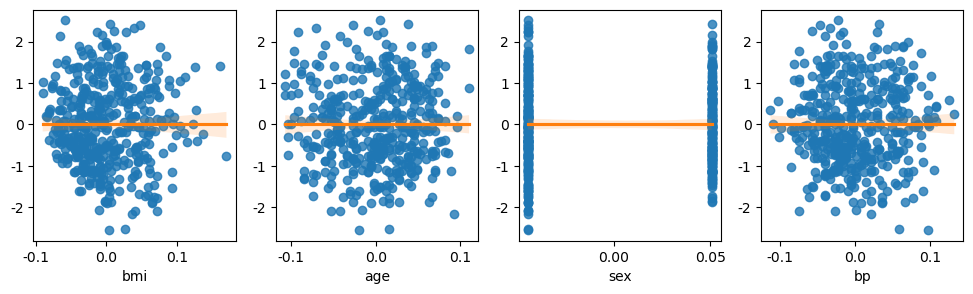

In [62]:
print("2. 등분산성 가정 확인: ")
import seaborn as sns
fig, ax = plt.subplots(1,4, figsize=(12,3))
for feature, ax in zip(X.columns, ax.ravel()):
    sns.regplot(x=X[feature], y=sresid, line_kws={'color':'C1'}, ax=ax)
plt.show()
## 각 독립변수와 잔차의 분산이 일정하면 가운데 회귀선이 수평하게 표시된다. 표준화 잔차의 값이 +/-2를 벗어나면 이상값 또는 특이값을 예상할 수 있다.
## 모든 독립변수에서 잔차의 분산이 일정한 것으로 보인다. 

In [63]:
print("3. 독립성 가정 확인: ")
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(resid)
print(" Durbin-watson 통계량 {:.3f}".format(dw))
## dw값이 2에 가까우면 잔차 간 독립이고, 0에 가까우면 양의 상관, 4에 가까우면 음의 상관이 있다고 본다. 따라서 잔차 간 독립인 것으로 보인다.

3. 독립성 가정 확인: 
 Durbin-watson 통계량 1.933


shapiro p-value: 0.017748321848297124
Breusch-Pagan p-value: 0.021150216578171635
DW 통계량: 1.9333372111978977


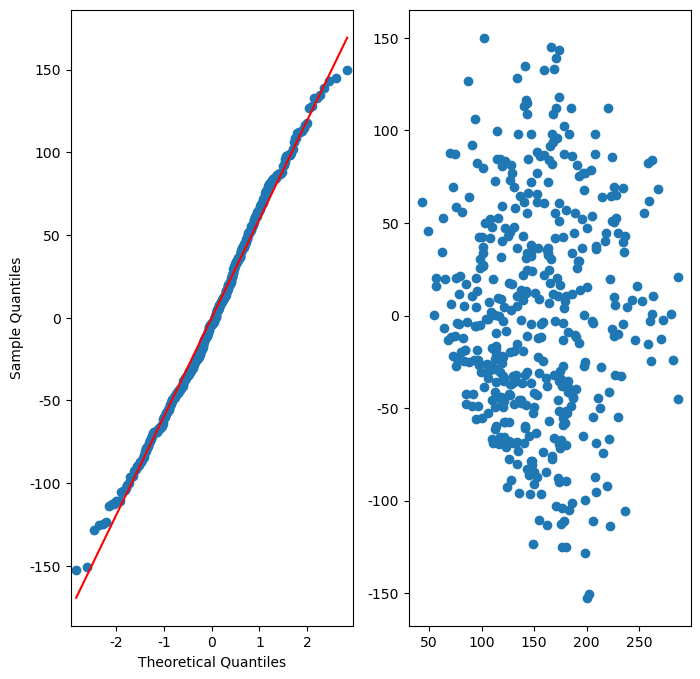

In [71]:
#### AI 추천 방법 #####
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

X_ = sm.add_constant(X)
model = sm.OLS(y, X_)
fitted = model.fit()
resid = fitted.resid # 잔차
pred = fitted.fittedvalues #예측값
sresid = zscore(resid) #표준화 잔차

fig, ax = plt.subplots(1,2)

# 정규성 검증: Shapiro-Wilk 검정 (H0: 데이터가 정규분포를 따른다)
stat, p = shapiro(resid)
print(f'shapiro p-value: {p}')
sm.qqplot(resid, line='s', ax=ax[0])  

# 등분산성 검증: Breusch-Pagan 검정 (H0: 등분산성이 존재한다 (잔차의 분산이 일정하다))
bp_stat, bp_p, _, _ = het_breuschpagan(resid, fitted.model.exog)
print(f'Breusch-Pagan p-value: {bp_p}')
plt.scatter(fitted.fittedvalues, resid, axes=ax[1])

# 독립성 검증: Durbin-Watson 통계량이 2에 가까우면 독립성 가정 만족
dw = durbin_watson(resid)
print(f'DW 통계량: {dw}')

#### 8-1-3. 규제 선형 회귀
- 규제(=정규화)를 적용하여 회귀계수의 과다 추정 및 모델의 과적합을 방지
- scikit-learn 사용시, alpha 클수록 규제 강도 높아져 모델 복잡성 및 과적합 가능성 감소

#### 릿지 회귀 (L2, 유클리디언 거리, 계수 0 불가)

In [69]:
# 앞서 불러온 데이터셋 사용
X = diabetes.filter(['bmi', 'age', 'sex', 'bp'])
y = diabetes.filter(['target'])

# 일반화 성능 확인을 위해 데이터를 train set과 test set으로 나눈다.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [70]:
from sklearn.linear_model import Ridge
# alpha값이 커질수록 규제가 커져 모델의 복잡성이 낮아진다. (일반화 된다.)
a = 0.9
ridge = Ridge(alpha=a).fit(X_train, y_train)
print(f"[alpha = {a}]")
train_s = ridge.score(X_train, y_train)
test_s = ridge.score(X_test, y_test)
print(" train set score: {:.3f}, test set score: {:.3f}".format(train_s, test_s))
for i, coef in enumerate(ridge.coef_.ravel()):
    print(" 회귀계수 {}: {:.2f}".format(i, coef))
print(" 절편: {:.2f}".format(ridge.intercept_[0]))

[alpha = 0.9]
 train set score: 0.311, test set score: 0.313
 회귀계수 0: 379.88
 회귀계수 1: 85.98
 회귀계수 2: -22.16
 회귀계수 3: 251.52
 절편: 151.95


In [71]:
a = 0.1
print(f"[alpha = {a}]")
ridge = Ridge(alpha=a).fit(X_train, y_train)
train_s = ridge.score(X_train, y_train)
test_s = ridge.score(X_test, y_test)
print(" train set score: {:.3f}, test set score: {:.3f}".format(train_s, test_s))
for i, coef in enumerate(ridge.coef_.ravel()):
    print(" 회귀계수 {}: {:.2f}".format(i, coef))
print(" 절편: {:.2f}".format(ridge.intercept_[0]))

[alpha = 0.1]
 train set score: 0.397, test set score: 0.389
 회귀계수 0: 687.35
 회귀계수 1: 96.35
 회귀계수 2: -101.83
 회귀계수 3: 407.39
 절편: 151.16


#### 라쏘 회귀 (L1, 맨하탄 거리, 계수 0 가능 (특정변수 제거 가능))
일반적으로 릿지 선호하지만, 특성이 많고 일부만 중요하다면 라쏘 선택 (분석/해석이 쉬움)

In [72]:
from sklearn.linear_model import Lasso
# alpha값이 커질수록 규제가 커져 모델의 복잡성이 낮아진다. (일반화 된다.)
a = 0.9
lasso = Lasso(alpha=a).fit(X_train, y_train)
print(f"[alpha = {a}]")
train_s = lasso.score(X_train, y_train)
test_s = lasso.score(X_test, y_test)
print(" train set score: {:.3f}, test set score: {:.3f}".format(train_s, test_s))
for i, coef in enumerate(lasso.coef_.ravel()):
    print(" 회귀계수 {}: {:.2f}".format(i, coef))
print(" 절편: {:.2f}".format(lasso.intercept_[0]))

[alpha = 0.9]
 train set score: 0.306, test set score: 0.324
 회귀계수 0: 486.10
 회귀계수 1: 0.00
 회귀계수 2: -0.00
 회귀계수 3: 140.11
 절편: 151.99


In [73]:
a = 0.1
print(f"[alpha = {a}]")
lasso = Lasso(alpha=a).fit(X_train, y_train)
train_s = lasso.score(X_train, y_train)
test_s = lasso.score(X_test, y_test)
print(" train set score: {:.3f}, test set score: {:.3f}".format(train_s, test_s))
for i, coef in enumerate(lasso.coef_.ravel()):
    print(" 회귀계수 {}: {:.2f}".format(i, coef))
print(" 절편: {:.2f}".format(lasso.intercept_[0]))

[alpha = 0.1]
 train set score: 0.398, test set score: 0.399
 회귀계수 0: 738.61
 회귀계수 1: 51.05
 회귀계수 2: -67.16
 회귀계수 3: 404.61
 절편: 151.11


#### 엘라스틱 넷 (L1+L2, ll_ratio로 비율 결정)

In [74]:
from sklearn.linear_model import ElasticNet
# alpha는 패널티 조건을 곱하는 상수로서 0이면 LinearRegression과 동일
# l1_ratio는 0~1 사이 값을 가지며, L1과 L2 규제의 조합을 의미함. 값이 0이면, L2 규제를 적용하고, 값이 1이면 L1 규제를 적용
a = 0.1
l1_ratio = 0.1
en = ElasticNet(alpha=a, l1_ratio=l1_ratio).fit(X_train, y_train)
print(f"[alpha = {a}, l1_ratio = {l1_ratio}]")
train_s = en.score(X_train, y_train)
test_s = en.score(X_test, y_test)
print(" train set score: {:.3f}, test set score: {:.3f}".format(train_s, test_s))
for i, coef in enumerate(en.coef_.ravel()):
    print(" 회귀계수 {}: {:.2f}".format(i, coef))
print(" 절편: {:.2f}".format(en.intercept_[0]))

[alpha = 0.1, l1_ratio = 0.1]
 train set score: 0.027, test set score: 0.026
 회귀계수 0: 22.88
 회귀계수 1: 7.45
 회귀계수 2: 1.19
 회귀계수 3: 17.02
 절편: 152.91


In [75]:
a = 0.1
l1_ratio = 0.9
print(f"[alpha = {a}, l1_ratio = {l1_ratio}]")
en = ElasticNet(alpha=a, l1_ratio=l1_ratio).fit(X_train, y_train)
train_s = en.score(X_train, y_train)
test_s = en.score(X_test, y_test)
print(" train set score: {:.3f}, test set score: {:.3f}".format(train_s, test_s))
for i, coef in enumerate(en.coef_.ravel()):
    print(" 회귀계수 {}: {:.2f}".format(i, coef))
print(" 절편: {:.2f}\n".format(en.intercept_[0]))

[alpha = 0.1, l1_ratio = 0.9]
 train set score: 0.161, test set score: 0.165
 회귀계수 0: 158.04
 회귀계수 1: 40.73
 회귀계수 2: 0.00
 회귀계수 3: 110.85
 절편: 152.54



#### 8-1-4. 일반화 선형 회귀 (GLM)
정규분포를 따르지 않는 종속변수에 연결 함수를 적용하여 독립변수에 따라 선형적으로 변화
- 지수, 감마 분포: negative inverse
- 포아송 분포: 로그 변환 (**포아송 회귀**: 종속변수가 개수, 빈도)
- 베르누이, 다항, 이항 분포: logit 변환 (**로지스틱 회귀**: 종속변수가 베르누이 분포, 0 or 1)

#### 로지스틱 회귀
- 장점: 모델 구현 쉬움, 빠른 효율적 계산, 해석 용이
- 단점: 이상치에 민감, 표본 크기 작으면 추청치 불안정
- 오즈비 = exp(회귀 계수) = X 단위 1 증가시 odds 증가량 / 잔차 분석 진행 X 

**[유효성 검정]**
- 회귀계수: Z통계량 --> Z분포 p-value  
  (Z통계량 제곱한 Wald 통계량: 자유도 1인 카이제곱 분포로 검정)
- 모델: 로그우도비 (LLR) 통계량 --> 카이제곱 분포 p-value

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from collections import Counter
from pandas import DataFrame
import numpy as np

# 데이터 불러오기
cancer = load_breast_cancer()
X = cancer.data[:, :4] # 유방암에 영향을 미치는 4개의 feature
X_names = cancer.feature_names[:4]
y = cancer.target # 유방암 여부
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
print("target class: ", Counter(y))

target class:  Counter({1: 357, 0: 212})


In [77]:
# 로지스틱 회귀 적합
# 파라미터 C값이 높을수록 규제가 약해지고, 모델 복잡성이 높아진다. 
LR = LogisticRegression(C=0.01, max_iter=1000)
LR.fit(X_train, y_train)
train_score = LR.score(X_train, y_train)
test_score = LR.score(X_test, y_test)

# 회귀식을 반환하는 함수 정의
def regression_formula(feature_names, coef, intercept):
    msg = "y = "
    for i, feature in enumerate(feature_names):
        coef = coef.ravel()
        msg += "+ {:.3f}*'{}' ".format(coef[i], feature)
    if intercept.shape == (1,):
        intercept = intercept[0]
    else:
        intercept = intercept
    msg += "+ {:.3f}".format(intercept)
    msg = msg[:4] + msg[6:]
    return msg

print("train score {:.3f}, test score {:.3f}\n".format(train_score, test_score))
print("로지스틱 회귀식: \n", regression_formula(X_names, LR.coef_, LR.intercept_))

train score 0.913, test score 0.874

로지스틱 회귀식: 
 y = 0.016*'mean radius' + -0.192*'mean texture' + -0.272*'mean perimeter' + 0.008*'mean area' + 24.001


In [9]:
# XBeta값(설명변수의 선형 결합)과 예측확률값(평균함수값) 구하기
data_idx = 0 #설명변수 X0의 index
XB = (X[data_idx]*LR.coef_).sum()+LR.intercept_[0] #회귀식에 X0값을 대입한 예측값
mu = 1/(1+np.exp(-XB)) #XB의 값을 변형하여 0~1 사이의 확률값으로 맵핑

# method인 decision_function과 predict_proba로 계산하기
XB2 = LR.decision_function(X[data_idx].reshape(-1,len(X[data_idx])))[0]
mu2 = LR.predict_proba(X[data_idx].reshape(-1,len(X[data_idx])))[0][1] 

print(" {}번 데이터의 features: {}".format(data_idx, X[data_idx]))
print(" {}번 데이터의 선형 함수 값 (XBeta): {:.3f} (={:.3f})".format(data_idx, XB, XB2))
print(" {}번 데이터의 시그모이드 함수 값 (mu): {:.3f} (={:.3f})".format(data_idx, mu, mu2) )

 0번 데이터의 features: [  17.99   10.38  122.8  1001.  ]
 0번 데이터의 선형 함수 값 (XBeta): -2.932 (=-2.932)
 0번 데이터의 시그모이드 함수 값 (mu): 0.051 (=0.051)


In [12]:
#기본 cut-off value(임계값)는 0.5: 확률값이 0.5 이상이면 1, 이하이면 0으로 분류
prob = LR.predict_proba(X) #각 클래스에 대한 예측확률값
## predict_proba: mu 계산, decision_function: XBeta 계산
pred = LR.predict(X) # 예측값
result = DataFrame(prob)
result['pred'] = pred
result['y'] = y
print("각 클래스일 확률에 따른 예측분류값과 실제분류값:\n", result.head(4))

각 클래스일 확률에 따른 예측분류값과 실제분류값:
           0         1  pred  y
0  0.949417  0.050583     0  0
1  0.987738  0.012262     0  0
2  0.994990  0.005010     0  0
3  0.090167  0.909833     1  0


In [13]:
# 회귀계수의 해석
feat_idx = 2 #확인할 feature의 index 선택
spec_X = X[data_idx]

# 회귀계수 확인
print("feature '{}'의 회귀계수 {:.3f}".format(X_names[feat_idx], LR.coef_[0][feat_idx]))
print(" ==> exp(회귀계수): {:.3f}\n".format(np.exp(LR.coef_[0][feat_idx])))

# 특정 feature의 값 한단위 증가 전 데이터와 오즈, 오즈비 확인
pred_y = LR.predict_proba(spec_X.reshape(-1,len(spec_X)))[0][1]
before_odds = pred_y/(1-pred_y)
print(" (증가 전) {}번 데이터의 features: {}".format(data_idx, spec_X))
print(" (증가 전)'{}'의 값이 {:.3f}일 때, y는 {:.3f}, odds(y/(1-y))는 {:.3f}\n".format(X_names[feat_idx], spec_X[feat_idx], pred_y, before_odds))

# 특정 feature의 값 한단위 증가 후 데이터와 오즈, 오즈비 확인
spec_X[feat_idx] = spec_X[feat_idx] +1
print(" (증가 후) {}번 데이터의 features: {}".format(data_idx, spec_X))
pred_y2 = LR.predict_proba(spec_X.reshape(-1,len(spec_X)))[0][1]
after_odds = pred_y2/(1-pred_y2)
print(" (증가 후)'{}'의 값이 {:.3f}일 때, y는 {:.3f},  odds(y/(1-y))는 {:.3f}(={:.3f})".format(X_names[feat_idx], spec_X[feat_idx], pred_y2, (pred_y2 / (1-pred_y2)), before_odds*np.exp(LR.coef_[0][feat_idx])))

print("\n ==> x가 한단위 증가하기 후의 오즈는 증가 전 오즈의 {:.3f}배가 된다. (증가 후 오즈/증가 전 오즈 = 오즈비)".format(after_odds/before_odds))

## x가 한단위 증가하면, 증가 후 오즈가 증가 전의 0.761배 된다는 의미이다. 이 0.761을 오즈비라고 한다.
## 즉, 해당 feature는 값이 증가할수록 반응변수의 확률값이 점점 줄어들게 된다.

feature 'mean perimeter'의 회귀계수 -0.272
 ==> exp(회귀계수): 0.761

 (증가 전) 0번 데이터의 features: [  17.99   10.38  122.8  1001.  ]
 (증가 전)'mean perimeter'의 값이 122.800일 때, y는 0.051, odds(y/(1-y))는 0.053

 (증가 후) 0번 데이터의 features: [  17.99   10.38  123.8  1001.  ]
 (증가 후)'mean perimeter'의 값이 123.800일 때, y는 0.039,  odds(y/(1-y))는 0.041(=0.041)

 ==> x가 한단위 증가하기 후의 오즈는 증가 전 오즈의 0.761배가 된다. (증가 후 오즈/증가 전 오즈 = 오즈비)


In [22]:
# 분류 성능 최적화를 위해 cut-off value를 다르게 설정하기도 한다.
# Youden Index (Youden's J statistic)는 기본적으로 민감도 + 특이도 - 1이라는 
# 매우 단순한 계산식을 통해 특이도와 민감도의 합이 최대가 되는 점을 구하는 방법이다. 이를 통해 최적의 cut-off value를 찾을 수 있다.
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, prob[:, 1]) #실제값과 예측 확률값으로 fpr, tpr, thresholds를 계산
J = tpr - fpr  # 민감도(tpr) + 특이도 (1-fpr) - 1 = tpr + 1 - fpr - 1 = tpr - fpr
idx= np.argmax(J)
best_threshold = thresholds[idx]
best_tpr = tpr[idx]
best_fpr = fpr[idx]
print("최적의 cut-off value: {:.3f}".format(best_threshold))
# 해당 모델은 최적의 cut-off value 0.526과 기본 설정값 0.5가 근사하지만, 
# 어떤 경우 최적의 분류 결과를 위한 cut-off value가 0.5에서 많이 벗어난 값이 될 수도 있다. 

최적의 cut-off value: 0.526


In [78]:
# statsmodels를 통해서도 회귀 적합할 수 있다. 다만, sklearn에서 적합한 회귀식과 다른 결과가 나오게 되는데, 
# 그 이유는 sklearn에서 자동으로 규제(regularization)를 적용하고 있기 때문이다. 
# sklearn의 C를 매우 큰 수로 설정하여 규제가 없다시피 하면, 두 라이브러리의 회귀식이 유사 해진다.
import statsmodels.api as sm
from scipy.stats import chi2
X_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_train)
fitted = model.fit()

# 로지스틱회귀 모델의 유의성 확인
test_a = 0.05 #유의수준
LLR = -2*(fitted.llnull - fitted.llf) #LLR (로그우도비)
cv = chi2.ppf(1-test_a, fitted.df_model) #LLR이 임계값보다 크면 모형이 유의하다.
sp = 1-chi2.cdf(LLR, fitted.df_model) #오른쪽 검정
print("\nLog-Likelihood: {:.3f}, LL-Null: {:.3f}".format(fitted.llf, fitted.llnull))
print("LLR: {:.3f}(= {:.3f}), critical value(임계값): {:.3f}".format(fitted.llr, LLR, cv))
print("LLR p-value: {:.3f}(= {:.3f})".format(sp, fitted.llr_pvalue))
print("R2: {:.3f}(= {:.3f})".format(fitted.prsquared, 1-fitted.llf/fitted.llnull))
## 해당 모델은 통계적으로 유의하다고 볼 수 있다.

Optimization terminated successfully.
         Current function value: 0.169550
         Iterations 10

Log-Likelihood: -72.229, LL-Null: -281.440
LLR: 418.423(= 418.423), critical value(임계값): 9.488
LLR p-value: 0.000(= 0.000)
R2: 0.743(= 0.743)


In [79]:
# statsmodels의 요약 결과 확인
print(fitted.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  426
Model:                          Logit   Df Residuals:                      421
Method:                           MLE   Df Model:                            4
Date:                Thu, 10 Apr 2025   Pseudo R-squ.:                  0.7434
Time:                        17:09:10   Log-Likelihood:                -72.229
converged:                       True   LL-Null:                       -281.44
Covariance Type:            nonrobust   LLR p-value:                 2.906e-89
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1470      8.502      0.017      0.986     -16.516      16.810
x1            10.3953      2.119      4.906      0.000       6.243      14.548
x2            -0.2622      0.057     -4.577      0.0

In [23]:
# x1의 회귀계수의 유의성 확인하기
# 위의 요약 결과에서는 회귀계수의 유의성 확인을 위해 z통계량을 사용하고 있으나, 아래와 같이 z통계량을 제곱한 wald통계량을 통해서도 회귀계수의 유의성을 확인할 수 있다.
z = (10.3953/2.119)
waldstat = z**2 #위의 report에서 확인한 x1의 회귀계수와 표준오차
cv = chi2.ppf(1-test_a, 1)
sp = 1-chi2.cdf(waldstat, 1)
print(f"Z 통계량 {z:.3f}")
print("wald 통계량 {:.3f}, 임곗값: {:.3f}".format(waldstat, cv))
print("유의수준 {:.3f}, 해당 통계량의 유의확률 {:.3f}".format(test_a, sp))
# 따라서 해당 회귀계수는 통계적으로 유의하다

Z 통계량 4.906
wald 통계량 24.066, 임곗값: 3.841
유의수준 0.050, 해당 통계량의 유의확률 0.000


#### 포아송 회귀
- exp(회귀 계수) = X 단위 1 증가시 빈도수 증가량

**[유효성 검정]**
- 회귀계수: Z 통계량 --> Z분포 p-value  
  (Z통계량 제곱한 Wald 통계량: 자유도 1인 카이제곱 분포로 검정)
- 모델 (특이하게, H0: 희귀모델 유효하다 --> 즉, **p-value가 커야 모델 유효**)
  1) Pearson 통계량 --> 카이제곱 분포 (df= n-k-1) 
  2) deviance 통계량 --> 카이제곱 분포 (df= n-k-1)

y의 분포: 


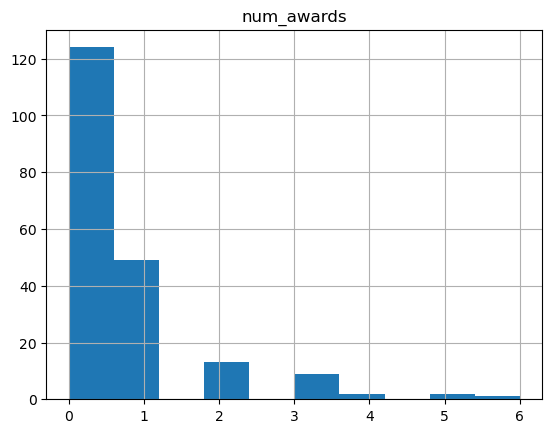

In [81]:
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from pandas import DataFrame, read_csv, get_dummies
from matplotlib import pyplot as plt
# [데이터 출처] https://stats.oarc.ucla.edu/r/dae/poisson-regression/

# 데이터 불러오기
# 종속변수인 'num_awards'가 정규분포가 아닌 포아송 분포를 따른다고 본다.
awards = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/8-1-4_awards.csv')
X = awards.filter(['prog', 'math']) # 등록한 프로그램 타입, 기말고사 수학 성적
# 프로그램 타입: 1. general, 2. academic, 3. vocational
X = get_dummies(X, drop_first=True, columns=['prog'])
y = awards.filter(['num_awards']) # 한 고등학교에서 학생들이 받은 상의 개수
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("y의 분포: ")
y.hist()
plt.show()

In [83]:
# 포아송 회귀 적합
# 파라미터 alpha가 커질수록 규제가 커지고, alpha가 0이면 규제가 없는 것과 같다. 
PR = PoissonRegressor(alpha=0.2)
PR.fit(X_train, y_train.values.ravel())
train_score = PR.score(X_train, y_train.values.ravel())
test_score = PR.score(X_test, y_test.values.ravel())

pred = PR.predict(X) # 예측값
result = DataFrame()
result['pred'] = pred
result['y'] = y

# 회귀식을 반환하는 함수 정의
def regression_formula(feature_names, coef, intercept):
    msg = "y = "
    for i, feature in enumerate(feature_names):
        coef = coef.ravel()
        msg += "+ {:.3f}*'{}' ".format(coef[i], feature)
    if intercept.shape == (1,):
        intercept = intercept[0]
    else:
        intercept = intercept
    msg += "+ {:.3f}".format(intercept)
    msg = msg[:4] + msg[6:]
    return msg

print("train score {:.3f}, test score {:.3f}\n".format(train_score, test_score))
print("포아송 회귀식: \n", regression_formula(X.columns, PR.coef_, PR.intercept_))

train score 0.327, test score 0.301

포아송 회귀식: 
 y = 0.078*'math' + 0.311*'prog_2' + -0.119*'prog_3' + -5.053


In [84]:
# XBeta값(설명변수의 선형 결합)과 지수 함수값(평균함수값) 구하기
data_idx = 194
XB = (X.iloc[data_idx, :]*PR.coef_).sum()+PR.intercept_ #회귀식에 x값을 대입한 값
mu = PR.predict(X.iloc[data_idx, :].values.reshape(-1,len(X.columns)))[0]
mu2 = np.exp(XB)

print(" {}번 데이터의 features: {}".format(data_idx, X.iloc[data_idx, :].values))
print(" {}번 데이터의 선형 함수 값 (XBeta): {:.3f}".format(data_idx, XB))
print(" {}번 데이터의 지수 함수 값 (mu): {:.3f} (={:.3f})".format(data_idx, mu, mu2) )

 194번 데이터의 features: [60 True False]
 194번 데이터의 선형 함수 값 (XBeta): -0.052
 194번 데이터의 지수 함수 값 (mu): 0.949 (=0.949)


C:\Users\sunwa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(


In [85]:
pred = PR.predict(X)
result = DataFrame()
result['pred'] = pred
result['Xbeta'] = np.log(pred)
result['y'] = y
print("예측빈도값과 실제빈도값:\n", result.tail(6))
## 모델 자체의 성능이 좋지 못한 상황이지만, 198번 데이터를 제외한 나머지 데이터들은 실제값에 근사하게 예측해냈다.

예측빈도값과 실제빈도값:
          pred     Xbeta  y
194  0.949226 -0.052109  1
195  2.242673  0.807668  2
196  1.995194  0.690741  2
197  2.242673  0.807668  1
198  2.424996  0.885830  0
199  2.622142  0.963992  3


In [86]:
# 회귀계수의 해석
feat_idx = 0
spec_X = X.iloc[data_idx, :].values

# 회귀계수 확인
print("feature '{}'의 회귀계수 {:.3f}: ".format(X.columns[feat_idx], PR.coef_[feat_idx]))
print(" ==> exp(회귀계수): {:.3f}\n".format(np.exp(PR.coef_[feat_idx])))

# 특정 feature의 한단위 증가 전 데이터와 예측값 y 확인
before_pred = PR.predict(spec_X.reshape(-1, len(spec_X)))[0]
print(" (증가 전) {}번 데이터의 features: {}".format(data_idx, spec_X))
print(" (증가 전)'{}'의 값이 {:.3f}일 때, y는 {:.3f}".format(X.columns[feat_idx], spec_X[feat_idx], before_pred))

# 특정 feature의 한단위 증가 후 데이터와 예측값 y 확인
spec_X[feat_idx] = spec_X[feat_idx] +1
after_pred = PR.predict(spec_X.reshape(-1,len(spec_X)))[0]
print(" (증가 후) {}번 데이터의 features: {}".format(data_idx, spec_X))
print(" (증가 후)'{}'의 값이 {:.3f}일 때, y는 {:.3f}".format(X.columns[feat_idx], spec_X[feat_idx], after_pred))

print("\n ==> x가 한단위 증가한 후의 빈도수는 증가 전 빈도수의 {:.3f}배가 된다. (= 증가 후 빈도수 / 증가 전 빈도수)".format(after_pred/before_pred))

## x가 한단위 증가하면, 증가 후 빈도수가 증가 전의 1.081배 된다는 의미이다.
## 즉, 해당 feature는 값이 증가할수록 반응변수의 확률값이 점점 증가하게 된다.

feature 'math'의 회귀계수 0.078: 
 ==> exp(회귀계수): 1.081

 (증가 전) 194번 데이터의 features: [60 True False]
 (증가 전)'math'의 값이 60.000일 때, y는 0.949
 (증가 후) 194번 데이터의 features: [61 True False]
 (증가 후)'math'의 값이 61.000일 때, y는 1.026

 ==> x가 한단위 증가한 후의 빈도수는 증가 전 빈도수의 1.081배가 된다. (= 증가 후 빈도수 / 증가 전 빈도수)


C:\Users\sunwa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(
C:\Users\sunwa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(


In [87]:
# statsmodels를 통해서도 회귀 적합할 수 있다. 다만, sklearn에서 적합한 회귀식과 다른 결과가 나오게 되는데, 
# sklearn에서 자동으로 규제를 적용하고 있기 때문이다. sklearn의 alpha를 0으로 설정하여 규제가 없다시피 하면, 두 라이브러리의 회귀식이 유사 해진다.
import statsmodels.api as sm
X_train = X_train.astype(float)  # 더미변수를 bool형에서 float형으로 변환 필요
X_train = sm.add_constant(X_train)
model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
fitted = model.fit()
test_a = 0.05
cv = chi2.ppf(1-test_a, fitted.df_resid) #오른쪽 검정
print("critical value: {:.3f}".format(cv))

critical value: 175.198


In [88]:
# 포아송회귀 모델의 유의성 확인
# Pearson chi2 통계량 계산 (자유도가 n-k-1인 카이제곱분포를 따름)
pearson = DataFrame(y_train)
pearson['pred'] = fitted.fittedvalues
pearson['squared_gap'] = (pearson['num_awards'] - pearson['pred'])**2
pearson['squared_gap/pred'] = pearson['squared_gap']/pearson['pred']
pstats = pearson['squared_gap/pred'].sum()
pval = 1-chi2.cdf(pstats, fitted.df_resid)
print("pearson chi2 stats: {:.3f}(={:.3f}), p-value: {:.3f}".format(pstats, fitted.pearson_chi2, pval))

pearson chi2 stats: 163.211(=163.211), p-value: 0.157


In [89]:
# deviance 통계량 계산 (자유도가 n-k-1인 카이제곱분포를 따름)
deviance = DataFrame(y_train['num_awards'])
deviance['pred'] = fitted.fittedvalues
deviance['Log'] = np.log(deviance['num_awards']/deviance['pred'])*deviance['num_awards']
deviance['num-pred'] = deviance['num_awards'] - deviance['pred']
dstats = deviance['Log'].sum()*2 - deviance['num-pred'].sum()*2
pval2 = (1-chi2.cdf(dstats, fitted.df_resid))**2
print("deviance chi2 stats: {:.3f}, p-value: {:.3f}".format(dstats, pval2))
print("R2: {:.3f}".format(1-fitted.llf/fitted.llnull))
## 따라서 해당 모델은 Pearson chi2 및 deviance 검정 결과, 귀무가설을 기각할 수 없으므로 통계적으로 유의하다.

deviance chi2 stats: 140.625, p-value: 0.372
R2: 0.224


C:\Users\sunwa\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [90]:
# statsmodels의 요약 결과 확인
print(fitted.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_awards   No. Observations:                  150
Model:                            GLM   Df Residuals:                      146
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -136.21
Date:                Wed, 09 Apr 2025   Deviance:                       140.62
Time:                        21:50:32   Pearson chi2:                     163.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4088
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2428      0.777     -6.748      0.0

In [91]:
# math의 회귀계수의 유의성 확인하기
# 위의 요약 결과에서는 회귀계수의 유의성 확인을 위해 z통계량을 사용하고 있으나, 
# 아래와 같이 z통계량을 제곱한 wald통계량을 통해서도 회귀계수의 유의성을 확인할 수 있다.
z = (0.0673/0.012)
waldstat = z**2 #위의 report에서 확인한 math의 회귀계수와 표준오차
cv = chi2.ppf(1-test_a, 1)
sp = 1-chi2.cdf(waldstat, 1)
print(f"Z 통계량 {z:.3f}")
print("wald 통계량 {:.3f}, 임곗값: {:.3f}".format(waldstat, cv))
print("유의수준 {:.3f}, 해당 통계량의 유의확률 {:.3f}".format(test_a, sp))
# 따라서 해당 회귀계수는 통계적으로 유의하다

Z 통계량 5.608
wald 통계량 31.453, 임곗값: 3.841
유의수준 0.050, 해당 통계량의 유의확률 0.000


#### 8-1-5. 이상치에 강한 선형 회귀

#### Robust regression
- OLS는 잔차 제곱합을 이용하기에 이상치 왜곡 문제 발생
- 잔차의 제곱 대신 절대값의 합이 최소화 되는 계수 추정 --> Robust Regression
- HuberRegressor: epsilon으로 이상치 샘플 수 컨트롤, 낮을 수록 더 Robust!

In [5]:
from sklearn.linear_model import HuberRegressor
import numpy as np
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.datasets import make_regression
rng = np.random.RandomState(0)
## 이상치 포함하는 데이터 생성하기
# 1개의 feature를 가진 사이즈 30의 데이터 생성
X, y =  make_regression(n_samples=30, n_features=1, random_state=0, noise=4.0, bias=100.0)

# 4개의 outlier를 생성하여 데이터에 추가
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() #outlier의 반은 더 크게
X_outliers[2:, :] += X.min() - X.mean() #outlier의 반은 더 작게
y_outliers[:2] += y.min() - y.mean()
y_outliers[2:] += y.max() + y.mean()
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))

In [6]:
# Robust regression 적합
HR = HuberRegressor(epsilon=1).fit(X, y)
HR_pred = HR.predict(X)
print("Huber coefficients {}, score {:.3f}".format(HR.coef_, HR.score(X, y)))

# 선형회귀 적합
LR = LinearRegression().fit(X, y)
LR_pred = LR.predict(X)
print("Linear coefficients {}, score {:.3f}".format(LR.coef_, LR.score(X, y)))

Huber coefficients [94.20831622], score -0.820
Linear coefficients [-10.91352281], score 0.009


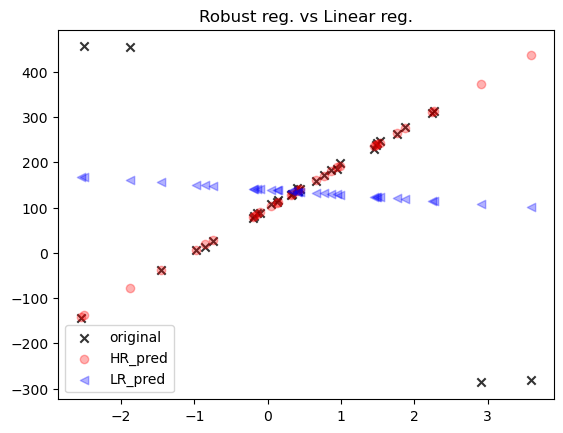

In [7]:
# 실제값과 두 회귀의 예측값을 비교
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1,1)
ax.set_title("Robust reg. vs Linear reg.")
ax.scatter(X, y, color = 'black', alpha=0.8, marker='x')
ax.scatter(X, HR_pred, color='red', alpha=0.3, marker='o')
ax.scatter(X, LR_pred, color='blue', alpha=0.3, marker='<')
plt.legend(['original', 'HR_pred', 'LR_pred'])
plt.show()

## Huber regression(Robust)이 Linear regression보다 이상치에 민감하지 않고 (강건하게) 일반적인 데이터를 잘 설명하도록 적합한 것으로 나타났다.

#### Quantile regression
- 특정 분위값 추정 (ex. 중앙값)하여 이상치의 영향을 거의 받지 않음
- 이분산 데이터도 회귀 모델링 가능 / L1 규제 가능 (alpha로 강도 조절)

In [8]:
from sklearn.linear_model import QuantileRegressor
# QuantileRegressor 적합
QR = QuantileRegressor(alpha=0).fit(X, y)
QR_pred = QR.predict(X)
print("Quantile coefficients {}, score {:.3f}".format(QR.coef_, QR.score(X, y)))
# 선형회귀 적합
LR = LinearRegression().fit(X, y)
LR_pred = LR.predict(X)
print("Linear coefficients {}, score {:.3f}".format(LR.coef_, LR.score(X, y)))

Quantile coefficients [94.2083527], score -0.820
Linear coefficients [-10.91352281], score 0.009


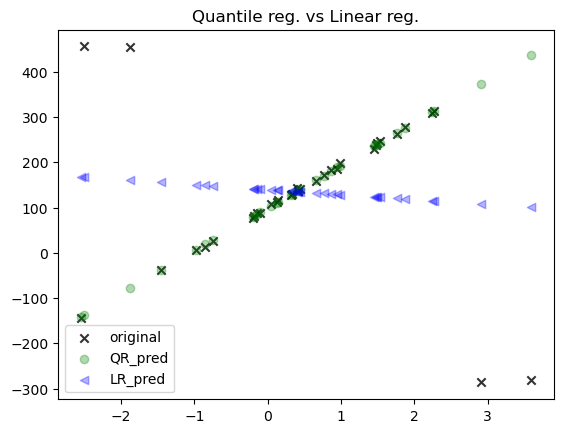

In [9]:
fig, ax = plt.subplots(1,1)
ax.set_title("Quantile reg. vs Linear reg.")
ax.scatter(X, y, color = 'black', alpha=0.8, marker='x')
ax.scatter(X, QR_pred, color='green', alpha=0.3, marker='o')
ax.scatter(X, LR_pred, color='blue', alpha=0.3, marker='<')
plt.legend(['original', 'QR_pred', 'LR_pred'])
plt.show()

### **8-2. 비선형회귀**

#### 다항회귀

sklearn R2: 0.880


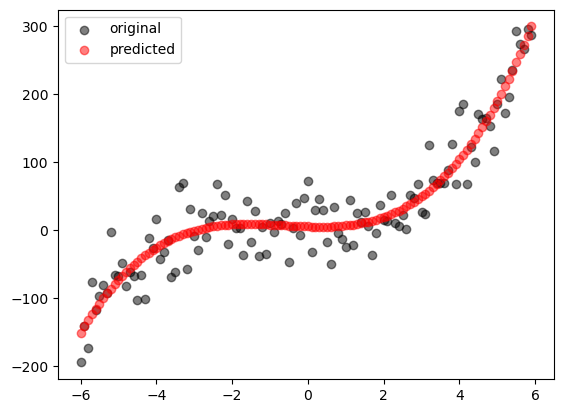

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     283.7
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           3.11e-53
Time:                        14:10:37   Log-Likelihood:                -588.27
No. Observations:                 120   AIC:                             1185.
Df Residuals:                     116   BIC:                             1196.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1678      4.537      1.139      0.2

In [10]:
# 데이터 생성
from pandas import DataFrame
import numpy as np
x = np.arange(-6.0, 6.0, 0.1)
y = 1*(x**3) + 2*(x**2) + 1*x + 3
y_noise = 30 * np.random.normal(size=x.size)
y = y + y_noise

# 다항 회귀 적합 1 (w/ sklearn)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
#degree: 다항식 차수 지정
#include_bias: 절편 추가여부

poly_features = PolynomialFeatures(degree=3, include_bias=True)
px = poly_features.fit_transform(x.reshape(-1,1))

LR = LinearRegression()
LR.fit(px, y)
pred = LR.predict(px)
print("sklearn R2: {:.3f}".format(LR.score(px, y)))

# 원본 데이터와 예측 데이터 비교
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1)
ax.scatter(x, y, alpha=0.5, color='black')
ax.scatter(x, pred, alpha=0.5, color='red')
ax.legend(['original', 'predicted'])
plt.show()

# 다항 회귀 적합 2 (w/ statsmodels)
import statsmodels.api as sm
model = sm.OLS(y, px) #sklearn의 PolynomialFeatures로 변환한 feature를 사용
fitted = model.fit()
print(fitted.summary())

In [12]:
x_ = sm.add_constant(x)
model2 = sm.OLS(y, x_) #sklearn의 PolynomialFeatures로 변환한 feature를 사용
fitted2 = model2.fit()
print(fitted2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     248.1
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           8.70e-31
Time:                        14:32:55   Log-Likelihood:                -647.58
No. Observations:                 120   AIC:                             1299.
Df Residuals:                     118   BIC:                             1305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.8012      4.915      6.063      0.0

#### 스플라인 회귀
- 다항 구간들을 부드러운 곡선 형태로 적합 (스플라인 구간 구분값: 매듭(Knot))
- n_splines = n_knots + degree - 1 (extrapolation="periodic'이면 n_knots-1)

sklearn R2: 0.880


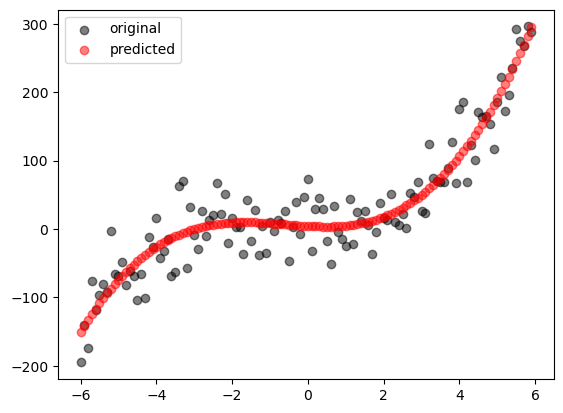

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     167.6
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           8.05e-51
Time:                        14:39:23   Log-Likelihood:                -588.17
No. Observations:                 120   AIC:                             1188.
Df Residuals:                     114   BIC:                             1205.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -693.7759    199.543     -3.477      0.0

In [13]:
# 앞선 데이터를 동일하게 사용
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression

# 스플라인 회귀 적합 1 (w/ sklearn)
spline = SplineTransformer(degree=3, n_knots=4)
sx = spline.fit_transform(x.reshape(-1,1))

LR = LinearRegression()
LR.fit(sx, y)
pred = LR.predict(sx)
print("sklearn R2: {:.3f}".format(LR.score(sx, y)))

# 원본 데이터와 예측 데이터 비교
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1)
ax.scatter(x, y, alpha=0.5, color='black')
ax.scatter(x, pred, alpha=0.5, color='red')
ax.legend(['original', 'predicted'])
plt.show()

# 스플라인 회귀 적합 2 (w/ statsmodels)
import statsmodels.api as sm
model = sm.OLS(y, sx) #sklearn의 SplineTransformer로 변환한 feature를 사용
fitted = model.fit()
print(fitted.summary())

#### 연습문제 #1

In [80]:
from pandas import read_csv, concat, get_dummies
realestate = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice8_BHP2.csv')
print(realestate)

     area_type  availability  size  total_sqft  bath  balcony   price
0        Super             0     3      1056.0     2        1   39.07
1         Plot             1     6      2600.0     5        3  120.00
2        Super             1     5      1521.0     3        1   95.00
3        Super             1     3      1170.0     2        1   38.00
4         Plot             1     6      2785.0     5        3  295.00
...        ...           ...   ...         ...   ...      ...     ...
7490     Super             1     5      1345.0     2        1   57.00
7491     Super             1     5      1715.0     3        3  112.00
7492  Built-up             1     8      3453.0     4        0  231.00
7493  Built-up             1     3      1141.0     2        1   60.00
7494     Super             0     7      4689.0     4        1  488.00

[7495 rows x 7 columns]


In [100]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

data = get_dummies(realestate, columns=['area_type'], drop_first=True, dtype='int')
X = data.drop('price', axis=1)
X = sm.add_constant(X)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

model = sm.OLS(y_train, X_train)
fitted = model.fit()
print(fitted.summary())

# 적합한 모델로 test set을 예측하여 결정계수를 확인
pred = fitted.predict(X_test)
print(">>> test score {:.3f}".format(r2_score(y_test, pred)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     656.3
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:17:49   Log-Likelihood:                -32305.
No. Observations:                5621   AIC:                         6.463e+04
Df Residuals:                    5612   BIC:                         6.469e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -62.1571      4.615  

#### 연습문제 #2

In [104]:
X_train2, X_test2 = X_train.copy(), X_test.copy()
for col in ['area_type_Carpet', 'area_type_Plot', 'area_type_Super']:
    X_train2[f"at_{col[10:]}:total_sqft"]=X_train2[col] * X_train2['total_sqft']
    X_test2[f"at_{col[10:]}:total_sqft"]=X_test2[col] * X_test2['total_sqft']

model = sm.OLS(y_train, X_train2)
fitted = model.fit()
print(fitted.summary())

# 적합한 모델로 test set을 예측하여 결정계수를 확인
pred = fitted.predict(X_test2)
print(">>> test score {:.3f}".format(r2_score(y_test, pred)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     556.3
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:19:38   Log-Likelihood:                -32088.
No. Observations:                5621   AIC:                         6.420e+04
Df Residuals:                    5609   BIC:                         6.428e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -28.2105 

#### 연습문제 #3

In [103]:
# total_sqft의 이차항을 추가한 X_train3, X_test3 생성
X_train3, X_test3 = X_train2.copy(), X_test2.copy()
X_train3["total_sqft2"] = X_train2['total_sqft']**2
X_test3["total_sqft2"] = X_test2['total_sqft']**2

# 신규 feature를 생성한 데이터로 선형회귀 분석을 수행
model3 = sm.OLS(y_train, X_train3)
fitted3 = model3.fit()
print(fitted3.summary()) # 적합한 선형회귀 모델 결과를 확인

# 적합한 모델로 test set을 예측하여 결정계수를 확인
pred3 = fitted3.predict(X_test3)
print(">>> test score {:.3f}".format(r2_score(y_test, pred3)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     847.8
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:19:13   Log-Likelihood:                -31254.
No. Observations:                5621   AIC:                         6.253e+04
Df Residuals:                    5608   BIC:                         6.262e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -40.6111 

#### 연습문제 #4

In [109]:
# Cook's distance, DFBETAS, DFFITS, LeverageH 등 영향치 기준으로 데이터를 판단하여 영향치를 제거하거나,
# VIF를 통해 다중공선성이 있는 변수를 제거하거나, 
# AIC를 최소로하는 변수의 조합을 찾는 단계적 선택법으로 변수를 선택할 수 있다. 
# 여기에서는 통계적으로 유의하지 않은 변수들을 제거함으로써 최종 변수를 선택하고자 한다.

X_train4, X_test4 = X_train3.copy(), X_test3.copy()

# 회귀계수 분석을 위해 feature scaling 진행
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train4)
X_train4 = DataFrame(ss.transform(X_train4), columns=X_train4.columns)
X_test4 = DataFrame(ss.transform(X_test4), columns=X_test4.columns)
X_train4['const'] = 1
X_test4['const'] = 1

# 통계적으로 유의하지 않은 변수들 제거
del_feats = ['bath', 'at_Plot:total_sqft', 'availability']
X_train4 = X_train4.drop(del_feats, axis=1)
X_test4 = X_test4.drop(del_feats, axis=1)

# 신규 feature를 생성한 데이터로 선형회귀 분석을 수행
model4 = sm.OLS(y_train.values, X_train4)
fitted4 = model4.fit()
print(fitted4.summary()) # 적합한 선형회귀 모델 결과를 확인

# 적합한 모델로 test set을 예측하여 결정계수를 확인
pred4 = fitted4.predict(X_test4)
print(">>> test score {:.3f}".format(r2_score(y_test, pred4)))


'''
train score(R-squared) 0.644와 test score 0.726에 의하면, 해당 모델은 데이터에 대한 설명력이 있다고 볼 수 있으며, 
train/test set 성능 차이가 크지 않기 때문에 어느 정도 일반화된 모델이라고 볼 수 있다. 

모델의 통계적 유의성은 F-statistic 통계량의 p-value(Prob)가 유의수준 0.05보다 작기 때문에 모델은 통계적으로 유의하다고 볼 수 있다.
각 변수에 대한 회귀계수들의 t통계량에 따른 p-value가 모두 유의수준보다 작기 때문에 이 회귀계수들 역시 통계적으로 유의하다고 볼 수 있다.

또한, 잔차분석을 통해 회귀모형에 대한 가정인 정규성, 등분산성, 독립성을 만족하는지를 확인해야 한다. 
아래에서 Durbin-Watson 통계량이 2에 가까움으로써 독립성은 만족하고 있지만, 
Jarque-Bera 통계량의 p-value를 볼 때 유의수준보다 작기 때문에 정규성에 위배된다. 
이처럼 모델이 회귀모형의 가정을 충족하지 못하는 경우, 추가로 자료를 수집하거나 변수 변환의 방법을 통해 가정을 충족하도록 모델을 다시 생성해야 한다.
'''

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1128.
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:26:48   Log-Likelihood:                -31259.
No. Observations:                5621   AIC:                         6.254e+04
Df Residuals:                    5611   BIC:                         6.260e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   97.2994 

'\ntrain score(R-squared) 0.644와 test score 0.726에 의하면, 해당 모델은 데이터에 대한 설명력이 있다고 볼 수 있으며, \ntrain/test set 성능 차이가 크지 않기 때문에 어느 정도 일반화된 모델이라고 볼 수 있다. \n\n모델의 통계적 유의성은 F-statistic 통계량의 p-value(Prob)가 유의수준 0.05보다 작기 때문에 모델은 통계적으로 유의하다고 볼 수 있다.\n각 변수에 대한 회귀계수들의 t통계량에 따른 p-value가 모두 유의수준보다 작기 때문에 이 회귀계수들 역시 통계적으로 유의하다고 볼 수 있다.\n\n또한, 잔차분석을 통해 회귀모형에 대한 가정인 정규성, 등분산성, 독립성을 만족하는지를 확인해야 한다. \n아래에서 Durbin-Watson 통계량이 2에 가까움으로써 독립성은 만족하고 있지만, \nJarque-Bera 통계량의 p-value를 볼 때 유의수준보다 작기 때문에 정규성에 위배된다. \n이처럼 모델이 회귀모형의 가정을 충족하지 못하는 경우, 추가로 자료를 수집하거나 변수 변환의 방법을 통해 가정을 충족하도록 모델을 다시 생성해야 한다.\n'

In [105]:
import statsmodels.api as sm
from itertools import combinations
def stepwise_method(X, y, criterion='AIC'): #'BIC', 'CP', 'adj_R2'
    result = DataFrame()
    feature_combis = [] #변수 조합의 모든 경우의 수
    for i in range(1, len(X.columns)+1):
        feature_combis += list(combinations(X.columns, i))
    feature_combis.reverse() #p개수 내림차순
    
    for j, feature_combi in enumerate(feature_combis):
        X_ = X.filter(feature_combi)
        X_ = sm.add_constant(X_) #절편 추가
        model = sm.OLS(y, X_)
        fitted = model.fit() #모델 적합
        n = fitted.nobs #number of observations
        p = fitted.df_model #설명변수의 개수
        if j==0:
            MSE_full = fitted.mse_resid # full모델의 MSE
        
        #각 기준값 계산
        aic = fitted.aic
        bic = fitted.bic
        cp = sum((fitted.resid)**2)/MSE_full - (n-2*(p+1))
        adj_R2 = fitted.rsquared_adj
        
        #각 기준값 입력
        result.loc[j, 'feature_combi'] = ", ".join(list(fitted.params.keys()))
        result.loc[j, 'AIC'] = aic
        result.loc[j, 'BIC'] = bic
        result.loc[j, 'CP'] = cp
        result.loc[j, 'adj_R2'] = adj_R2
        
        if criterion in ['AIC', 'BIC']: #낮을수록 Best
            result = result.sort_values(by=criterion, ascending = True)
            best = result.iloc[0, 0]
        elif criterion in ['adj_R2']: #높을수록 Best
            result = result.sort_values(by=criterion, ascending = False)
            best = result.iloc[0, 0]
        elif criterion in ['CP']: #CP값이 작고, 변수의 개수와 유사할수록 Best
            best_idx = np.abs(result['CP']-result['feature_combi'].
                              apply(lambda x: x.count(',')+1)).sort_values(ascending=True).index
            result = result.loc[best_idx, :]
            best = result.iloc[0, 0]
        else:
            print("criterion options only cover AIC, BIC, CP, adj_R2.")
    return best, result

best, result = stepwise_method(X, y, criterion='AIC')
print("최적의 변수 조합: ", best)
print(f"전체 결과값: \n{result}\n")

for c in ['AIC', 'BIC', 'CP', 'adj_R2']:
    best, result = stepwise_method(X, y, c)
    print(f"기준 {c}에 의한 최적의 변수 조합 {best}")

최적의 변수 조합:  const, total_sqft, bath, area_type_Plot
전체 결과값: 
                                         feature_combi           AIC  \
343            const, total_sqft, bath, area_type_Plot  85584.101351   
399            const, total_sqft, bath, area_type_Plot  85584.101351   
308  const, availability, total_sqft, bath, area_ty...  85584.132181   
238  const, availability, total_sqft, bath, area_ty...  85584.132181   
288      const, size, total_sqft, bath, area_type_Plot  85584.244599   
..                                                 ...           ...   
510                                              const  91087.960044   
461              const, availability, area_type_Carpet  91088.920201   
489              const, availability, area_type_Carpet  91088.920201   
501                                const, availability  91089.165645   
509                                const, availability  91089.165645   

              BIC           CP        adj_R2  
343  85611.789316     3.123